In [1]:
%matplotlib inline

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [2]:
# from Udacity example given in lessons
# from https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = gray.shape[::-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


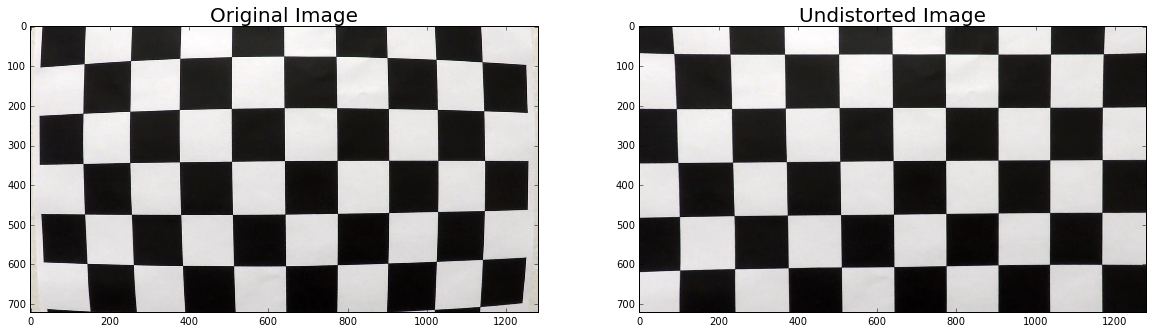

In [3]:
# Test the calibration on one of the example chessboards. 
# It's very obvious that the calibration has fixed the distortion. 
# again pretty much right from Udacity example given in lessons

# Test undistortion on a chessboard image
img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix colorspace
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# undistort the image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# save undistorted image
cv2.imwrite('output_images/calibration_undist.jpg', dst)

# Save the camera calibration results 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)


## Test on a real image
### Notice that the left bridge barrier seems to be 'steeper' in the undistroted image. Also, the hood of the car at the bottom of the image is different.

In [4]:
# Test undistortion on a test image
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix colorspace
img_size = (img.shape[1], img.shape[0])

# simple but re-usable later
def undistort(img):
    # undistort using previously found calibration settings
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = undistort(img)

# save undistorted image
cv2.imwrite('output_images/test1_undistorted.jpg', cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)


### Mask a region of interest to lower false positives
taken from previous lessons

In [5]:
def region_of_interest(img, vertices):
    """
    Applies image mask so we can ignore the noisy parts of the image we dont care bout
    From course QA video
    """
    # create a place for the mask to live
    mask = np.zeros_like(img)

    #  define a 3 channel or 1 channel dolor to fill the mask with
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # fill the mask with outr color
    cv2.fillPoly(mask,vertices,ignore_mask_color)

    #mask the image and return it
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image


### Perspective warping/transforming


In [6]:
def perspective_shift(image):
    height,width = image.shape[:2]
    # define source and destination points for transform

    # from the lessons
    img_size = (image.shape[1], image.shape[0])

#     src_corners = np.float32([[0.42*image.shape[1],0.64*image.shape[0]],
#                       [0.60*image.shape[1],0.64*image.shape[0]],
#                       [0.95*image.shape[1],0.94*image.shape[0]],
#                       [0.15*image.shape[1],0.94*image.shape[0]]])

#     offset = img_size[0]*.06
#     dest_corners = np.float32([[offset, 0], 
#                       [img_size[0]-offset, 0], 
#                       [img_size[0]-offset, img_size[1]], 
#                       [offset, img_size[1]]])
    
    # This should be done prgramatically in the real world.
    # but tried the above as found in class and it made things worse
    # so for now, shelving it
    src_corners = np.float32([[225,720],[590,450],[690,450],[1025,720]])
    dest_corners = np.float32([[275,720],[275,0],[1025,0],[1025,725]])    

#     print("src: ", src_corners)
#     print ("dst: ", dest_corners)
    
    # get the transform matrix and it's inverse 
    # we will need the inverse later for drawing the lane lines
    M = cv2.getPerspectiveTransform(src_corners, dest_corners)
    Minv = cv2.getPerspectiveTransform(dest_corners, src_corners)
    
    # cv2 warps the image so we have a top down view
    image_warped = cv2.warpPerspective(image, M, (width, height), flags=cv2.INTER_LINEAR)

    return image_warped, M, Minv

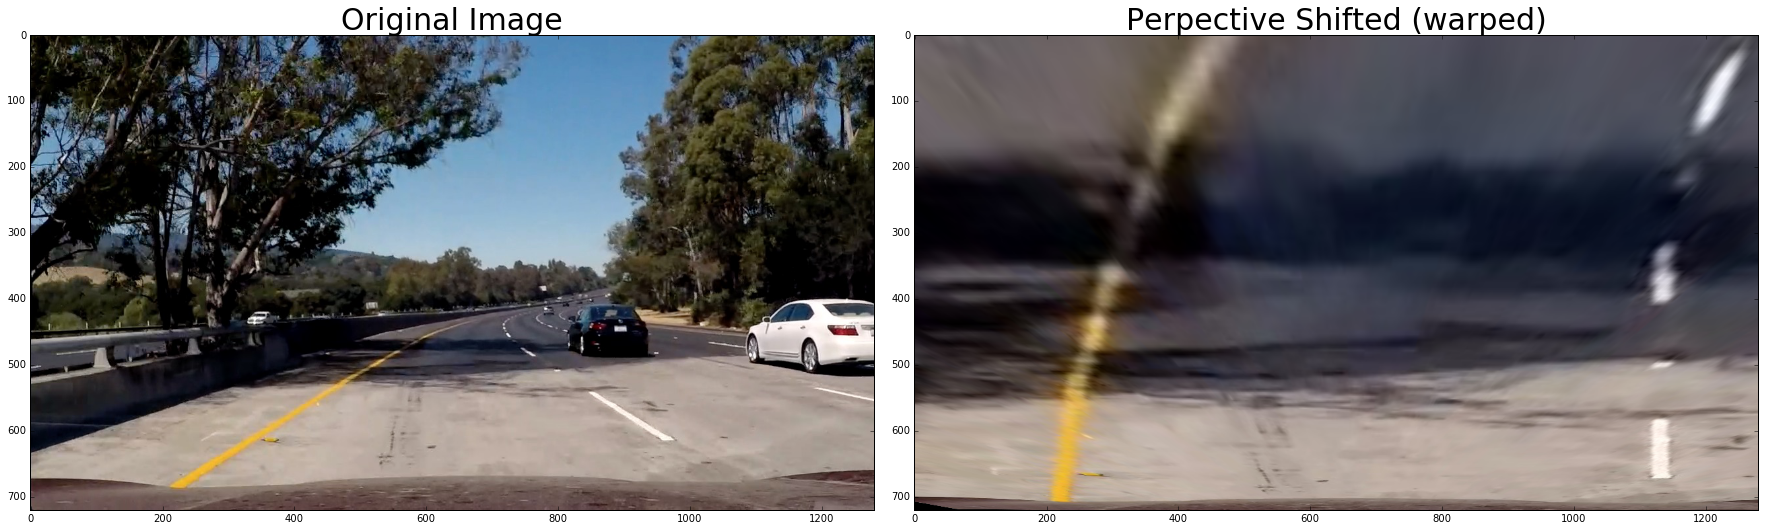

In [7]:
# test on an image
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace

# # crop just the area we want to look in
# imshape = image.shape
# vertices = np.array([[(0.42*imshape[1],0.64*imshape[0]), # top left x,y
#                       (0.60*imshape[1],0.64*imshape[0]), # top right
#                       (0.95*imshape[1],0.94*imshape[0]), # bottom right
#                       (0.15*imshape[1],0.94*imshape[0])]], # bottom left
#                     dtype=np.int32) 
# # print("vertices: ", vertices)
# image = region_of_interest(image, vertices)

# Show perspective shifted image
# unwarped_image, M, Minv = perspective_shift(image, src_corners, dest_corners)
unwarped_image, M, Minv = perspective_shift(image)

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(unwarped_image)
ax2.set_title('Perpective Shifted (warped)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


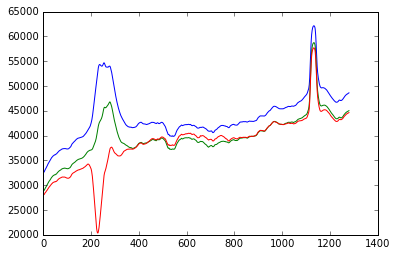

In [8]:
import numpy as np
import matplotlib.pyplot as plt

histogram = np.sum(unwarped_image[unwarped_image.shape[0]//2:,:], axis=0)

plt.gcf().clear()
plt.plot(histogram)

### Define functions for thresholding

In [9]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)   
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

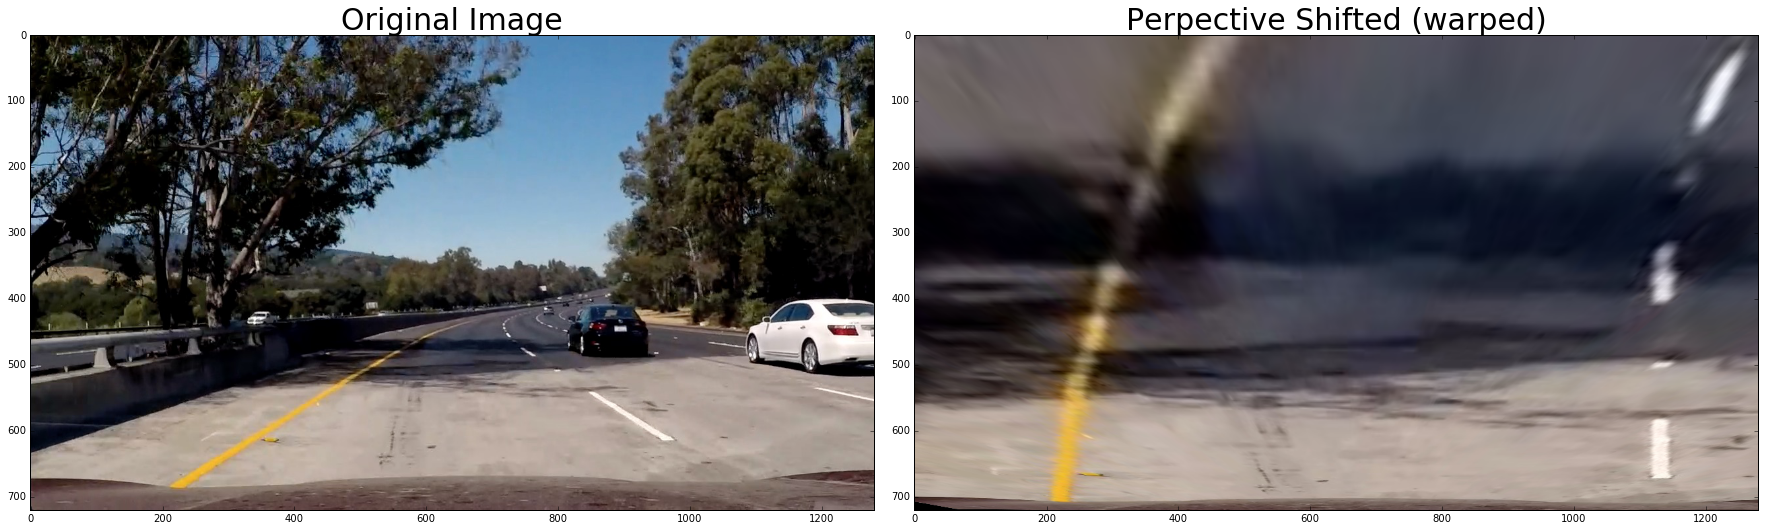

In [10]:
# test on an image
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace

# # crop just the area we want to look in
# imshape = image.shape
# vertices = np.array([[(0.42*imshape[1],0.64*imshape[0]), # top left x,y
#                       (0.60*imshape[1],0.64*imshape[0]), # top right
#                       (0.95*imshape[1],0.94*imshape[0]), # bottom right
#                       (0.15*imshape[1],0.94*imshape[0])]], # bottom left
#                     dtype=np.int32) 
# # print("vertices: ", vertices)
# image = region_of_interest(image, vertices)

# Show perspective shifted image
# unwarped_image, M, Minv = perspective_shift(image, src_corners, dest_corners)
unwarped_image, M, Minv = perspective_shift(image)

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(unwarped_image)
ax2.set_title('Perpective Shifted (warped)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


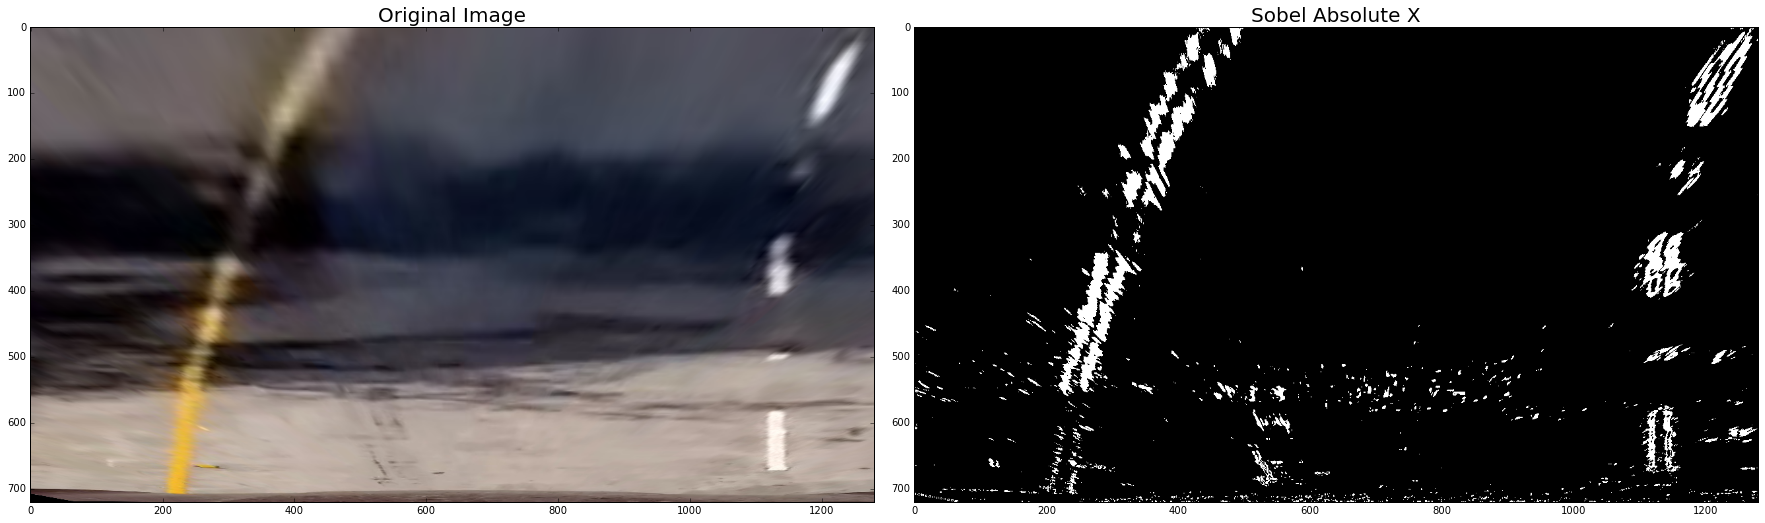

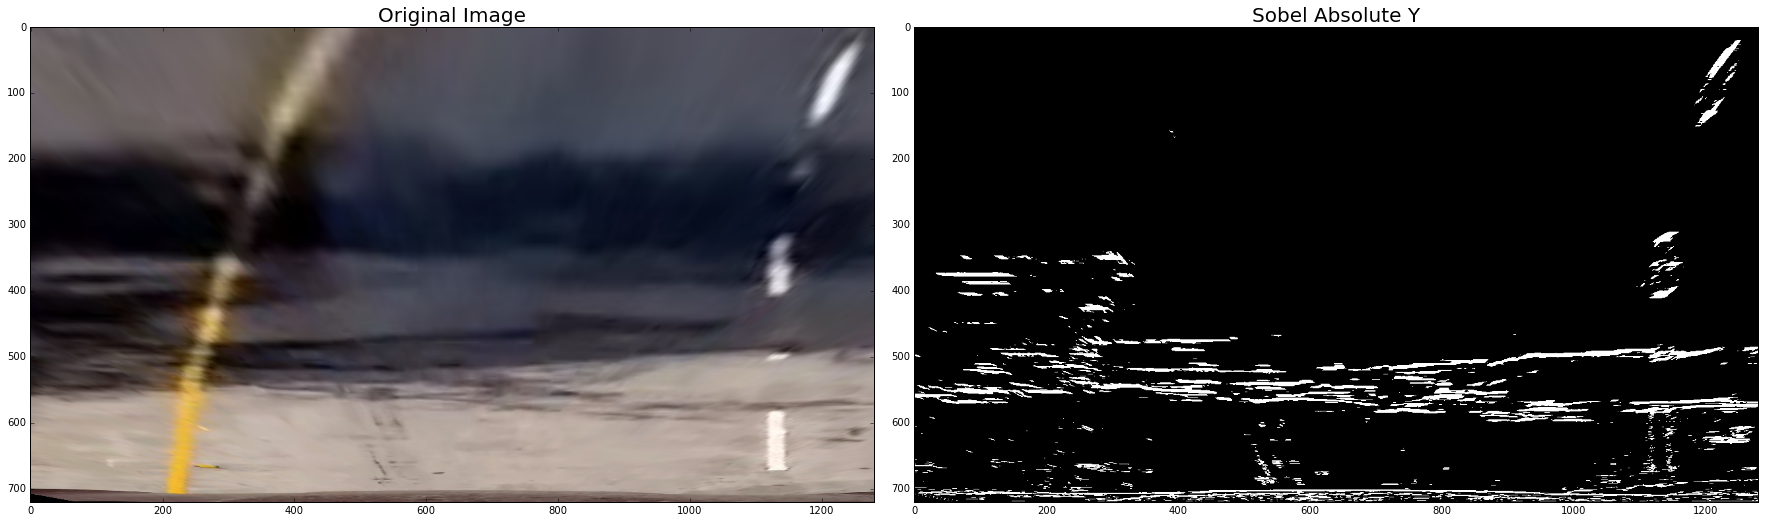

In [11]:
# Sobel transform the image
sobelx_img = abs_sobel_thresh(unwarped_image, 'x', 3, (20, 100))
sobely_img = abs_sobel_thresh(unwarped_image, 'y', 3, (20, 100))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(sobelx_img, cmap='gray')
ax2.set_title('Sobel Absolute X', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(sobely_img, cmap='gray')
ax2.set_title('Sobel Absolute Y', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [12]:
histogram = np.sum(sobelx_img[sobelx_img.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)

histogram = np.sum(sobely_img[sobely_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# combined_sobel = np.zeros_like(dir_img)
# combined_sobel[((sobelx_img == 1) & (sobely_img == 1))] = 1
# #combined_img[((sobelx_img == 1) & (mag_img == 1))] = 1
# histogram = np.sum(combined_sobel[combined_sobel.shape[0]//2:,:], axis=0)
# plt.plot(histogram)

In [13]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary_output

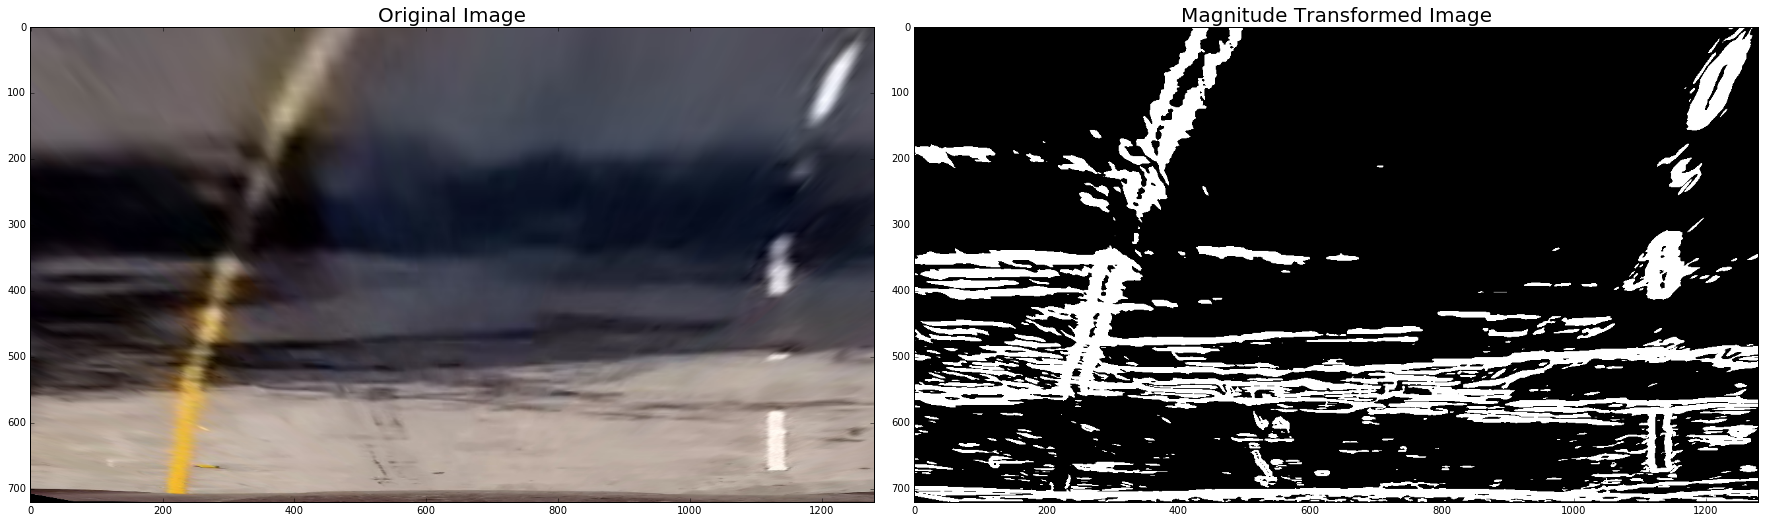

In [14]:
# magnitude transform the image
mag_img = mag_thresh(unwarped_image, sobel_kernel=11, thresh=(15, 255))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_img, cmap='gray')
ax2.set_title('Magnitude Transformed Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [15]:
histogram = np.sum(mag_img[mag_img.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)

In [16]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output =  np.zeros_like(absgraddir)
    
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

In [17]:
# directional gradient with sobel and magnitude 
dir_img = dir_threshold(unwarped_image, sobel_kernel=7, thresh=(0.0, 0.15))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dir_img, cmap='gray')
ax2.set_title('Directional Grad. Dir.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

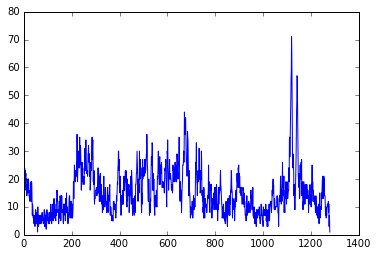

In [18]:
histogram = np.sum(dir_img[dir_img.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)

In [19]:
def hls_grad(img, hls_thresh=(150, 255)):

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    #150,255
    s_thresh_min = hls_thresh[0]
    s_thresh_max = hls_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    return s_binary

In [20]:
# hls and gradient combined
# as per 11.16
hlsg_image = hls_grad(unwarped_image, hls_thresh=(160, 255))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hlsg_image, cmap='gray')
ax2.set_title('HLS Grad. Dir.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

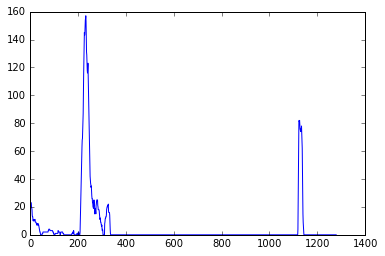

In [21]:
histogram = np.sum(hlsg_image[hlsg_image.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)


In [22]:
# utility function 
def combined_thresh(img, sobel_kernel=3, s_thresh=(15, 255), m_thresh=(20, 200), d_thresh=(0.0, 0.09), hls_thresh=(160, 255)):
    # Sobel transform the image
    sobelx_img = abs_sobel_thresh(img, orient='x',sobel_kernel=5, thresh=s_thresh)
    #sobely_img = abs_sobel_thresh(img, orient='y',sobel_kernel=5, thresh=s_thresh)
    
    # magnitude transform the image
    #mag_img = mag_thresh(img, sobel_kernel=11, thresh=m_thresh)
    
    # directional gradient with sobel and magnitude 
    #dir_img = dir_threshold(img, sobel_kernel=11, thresh=d_thresh)
    
    # HLS threshold - using S Channel
    hlsg_image = hls_grad(img, hls_thresh)
    
    #combine them    
    combined_img = np.zeros_like(sobelx_img)
    #combined_img[((sobelx_img == 1) & (sobely_img == 1)) | ((mag_img == 1) & (dir_img == 1))] = 1
    #combined_img[((sobelx_img == 1) & (hlsg_image == 1) | (mag_img == 1))] = 1
    combined_img[((sobelx_img == 1) | (hlsg_image == 1))] = 1
    
    
    return combined_img
    

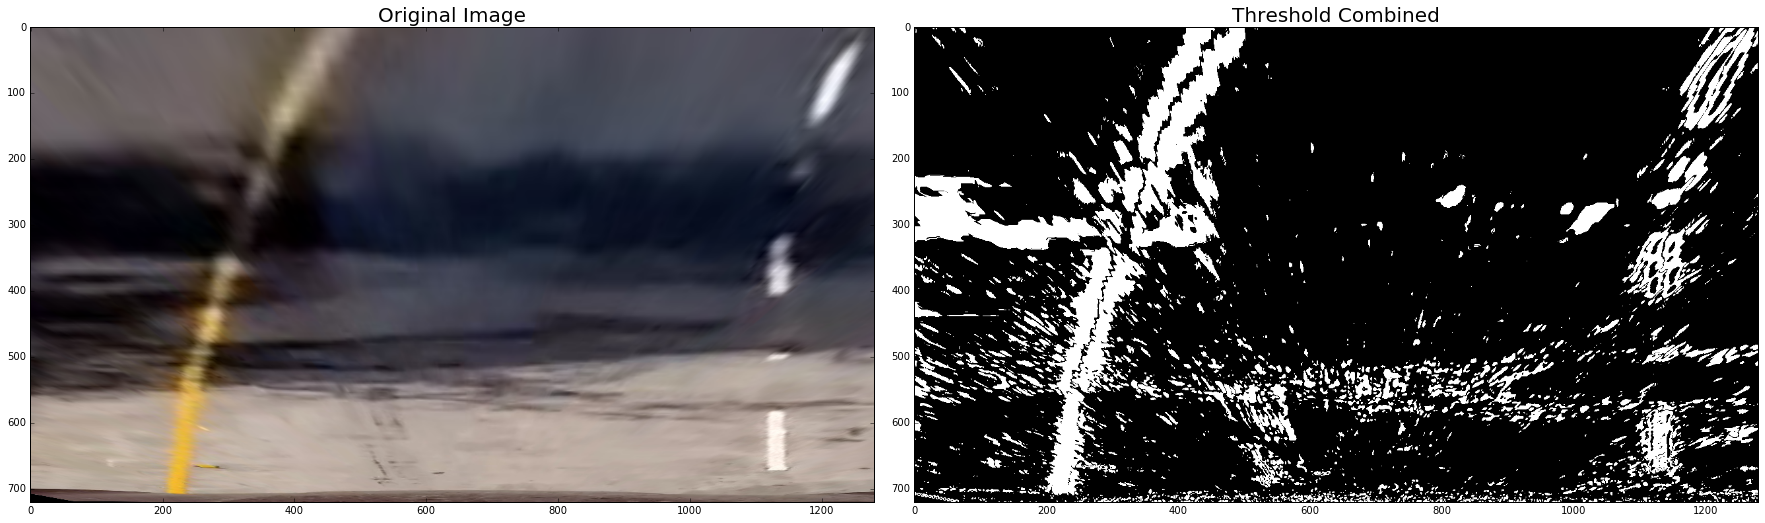

In [23]:
#combine them 
# combined_image = combined_thresh(unwarped_image, sobel_kernel=15, 
#     s_thresh=(15, 255), m_thresh=(15, 255), d_thresh=(0.0, 0.09), hls_thresh=(150, 255))

combined_image = combined_thresh(unwarped_image, sobel_kernel=15, 
    s_thresh=(10,100), hls_thresh=(160, 255))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_image, cmap='gray')
ax2.set_title('Threshold Combined', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [24]:
histogram = np.sum(combined_image[combined_image.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)

### As per lesson 16 - pretty much borrowed directly then adapted to use the above methods

In [25]:
# from lesson 16.34/35
#  method to Implement Sliding Windows and Fit a Polynomial
def sliding_window_fitpoly(binary_warped, test=False):
    # Take a histogram of the bottom half of the image 
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    if (test):
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
    # HYPERPARAMETERS 
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])   
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base 

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if (test):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        
    # Fit a second order polynomial to each
    left_fit, right_fit = (None, None)
    
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    if (test):
        print('pts:', leftx, lefty, rightx, righty )
        print ('fits:', left_fit, right_fit)
        # Generate x and y values for plotting
        ploty = np.linspace(0, unwarped_image.shape[0]-1, combined_image.shape[0] )
        #print ('ploty:', ploty)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = combined_image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        histogram = np.sum(out_img[out_img.shape[0]//2:,:], axis=0)
        plt.plot(histogram)
        plt.show()
        plt.gcf().clear()

        
        f, ax1 = plt.subplots(1, 1, figsize=(20,10))
        ax1.set_title('Visualize lane lines')
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')
        plt.show()
        plt.gcf().clear()
        
        histogram = np.sum(out_img[out_img.shape[0]//2:,:], axis=0)
        plt.plot(histogram)
        plt.show()
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds

pts: [149 150 211 ..., 459 460 461] [640 640 640 ...,  79  79  79] [1103 1104 1105 ..., 1247 1248 1249] [640 640 640 ...,  79  79  79]
fits: [  6.79714597e-04  -7.92086808e-01   4.65979372e+02] [  7.97989611e-04  -6.95325256e-01   1.24912434e+03]


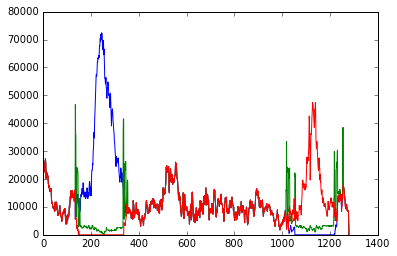

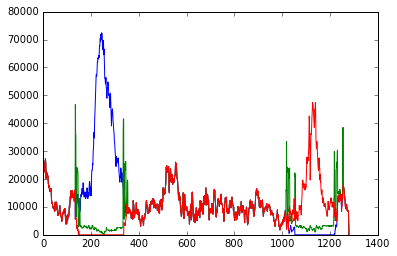

In [26]:
# test on an image
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test5.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace
# Show perspective shifted image
# image = undistort(image)
# # crop just the area we want to look in
# imshape = image.shape
# vertices = np.array([[(0.42*imshape[1],0.64*imshape[0]), # top left x,y
#                       (0.60*imshape[1],0.64*imshape[0]), # top right
#                       (0.95*imshape[1],0.94*imshape[0]), # bottom right
#                       (0.15*imshape[1],0.94*imshape[0])]], # bottom left
#                     dtype=np.int32) 
# print("vertices: ", vertices)
# image = region_of_interest(image, vertices)

unwarped_image, M, Minv = perspective_shift(image)
combined_image = combined_thresh(unwarped_image, sobel_kernel=3, s_thresh=(10, 100), hls_thresh=(125, 255))

left_fit, right_fit, left_lane_inds, right_lane_inds = \
    sliding_window_fitpoly(combined_image, True)

#print ('left_fit, right_fit, left_lane_inds, right_lane_inds',left_fit, right_fit, left_lane_inds, right_lane_inds)

In [27]:
def sliding_window_fitnewpoly(binary_warped, left_fit, right_fit, test=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)

    if (test):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        plt.show()
        plt.gcf().clear()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        plt.gcf().clear()
        
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


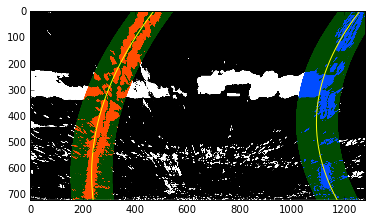

In [28]:
# test on an image
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test5.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace
# Show perspective shifted image
image = undistort(image)

unwarped_image, M, Minv = perspective_shift(image)
combined_image = combined_thresh(unwarped_image, sobel_kernel=15, s_thresh=(10, 100), hls_thresh=(125, 255))


left_fit, right_fit, left_lane_inds, right_lane_inds = \
    sliding_window_fitpoly(combined_image, False)

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = \
    sliding_window_fitnewpoly(combined_image,left_fit, right_fit, True)



### Calculate the radius of the curve


In [29]:
# from 16.37
def calc_curve(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    y_eval = np.max(ploty)
    
    #print("left_lane_inds: ", left_lane_inds)
                    
    # Define conversions in x and y from pixels space to meters
    # taken from the lessons
    ym_per_pix = 30/720 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # numbers above for curve are in meters
    
    # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
    #if right_fit is not None and left_fit is not None:
    car_position = img.shape[1]/2
    left_fit_x_int = left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]
    right_fit_x_int = right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]

    lane_center_position = (right_fit_x_int + left_fit_x_int) /2
    center = (car_position - lane_center_position) * xm_per_pix

    return left_curverad, right_curverad, center


In [30]:
print ('left_fit, right_fit, left_lane_inds, right_lane_inds:', left_fit, right_fit, left_lane_inds, right_lane_inds)
left_curverad, right_curverad, center = \
    calc_curve(combined_image, left_fit, right_fit, left_lane_inds, right_lane_inds)
print ('Radius of left and right edge:', left_curverad,'m, ', right_curverad,'m' )
print ('Center offset:', center,'m')


left_fit, right_fit, left_lane_inds, right_lane_inds: [  6.08563403e-04  -7.58655565e-01   4.70745538e+02] [  9.09643489e-04  -7.74405108e-01   1.25863908e+03] [148682 148683 148684 ...,   9298   9299   9300] [148751 148752 148753 ...,   9348   9349   9350]
Radius of left and right edge: 269.948036657 m,  181.782238464 m
Center offset: -0.350494097384 m


In [31]:
def draw_lane_lines(original_img, binary_img, left_fit, right_fit, Minv):
    new_img = np.copy(original_img)
    
    if left_fit is None or right_fit is None:
        return original_img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


In [32]:
# test on an image
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace
image = undistort(image)
# crop just the area we want to look in
imshape = image.shape
vertices = np.array([[(0.42*imshape[1],0.64*imshape[0]), # top left x,y
                      (0.60*imshape[1],0.64*imshape[0]), # top right
                      (0.95*imshape[1],0.94*imshape[0]), # bottom right
                      (0.15*imshape[1],0.94*imshape[0])]], # bottom left
                    dtype=np.int32) 
print("vertices: ", vertices)
image_crop = region_of_interest(image, vertices)

# perspective shifted image
unwarped_image, M, Minv = perspective_shift(image_crop)
combined_image = combined_thresh(unwarped_image, sobel_kernel=15, s_thresh=(10, 100), hls_thresh=(125, 255))

left_fit, right_fit, left_lane_inds, right_lane_inds = \
    sliding_window_fitpoly(combined_image, False)

left_curverad, right_curverad, center = \
    calc_curve(combined_image, left_fit, right_fit, left_lane_inds, right_lane_inds)

print ('Radius of left and right edge:', left_curverad,'m, ', right_curverad,'m' )
print ('Center offset:', center,'m')

lined_image = draw_lane_lines(image, combined_image, left_fit, right_fit, Minv)
plt.imshow(lined_image)


vertices:  [[[ 537  460]
  [ 768  460]
  [1216  676]
  [ 192  676]]]
Radius of left and right edge: 2496.97240269 m,  277.439314944 m
Center offset: -0.136455557062 m


In [42]:
def draw_telemetry(img, left_curverad, right_curverad, center):
    avg_curve = (left_curverad + right_curverad)/2
    
    new_img = np.copy(img)
    h = new_img.shape[0]
    
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'radius: ' + '{:04.2f}'.format(avg_curve) + 'm' 
    text = text + ' l = ' + '{:04.2f}'.format(left_curverad) + 'm'
    text = text + ' r = ' + '{:04.2f}'.format(right_curverad) + 'm'
    
    cv2.putText(new_img, text, (40,70), font, 1, (200,255,155), 2, cv2.LINE_AA)
    
    offset = ''
    if center > 0:
        offset = 'R'
    elif center < 0:
        offset = 'L'
    #abs_center_dist = abs(center_dist)
    text = 'center: '+ '{:04.3f}'.format(center) + 'm ' + offset
    cv2.putText(new_img, text, (40,120), font, 1, (200,255,155), 2, cv2.LINE_AA)
    
    return new_img


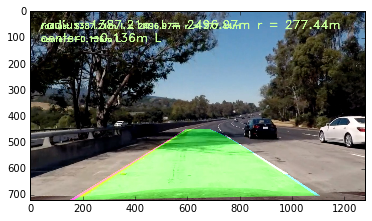

In [43]:
lined_image = draw_telemetry(lined_image, left_curverad, right_curverad, center)
plt.imshow(lined_image)

In [98]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0.0
        self.recent_radius_of_curvature = [np.array([False])]
        self.best_curve = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # track dropped frames 
        self.dropped_frames = 0
        # change rate
        self.fit_change = 0.0
        # curve change
        self.curve_change = 0.0

    def add_fit(self, fit, curve, center):
        if fit is not None:
            
            # if we have previously found fit calculate how much we have changed
            if np.average(self.current_fit) > 0.0:
                self.fit_change = abs(1-(np.average(self.current_fit)/np.average(fit)))
                self.curve_change = abs(1-(np.average(self.radius_of_curvature)/np.average(curve)))
            
            # if we change too much then it is probably an error and discard the frames measurements
            # settled on this percentage after some trial and error 
            if self.fit_change <= 0.05:
                # since we found a reasonable change, store it and trim
                self.current_fit = fit
                self.recent_xfitted.append(fit)
                if len(self.recent_xfitted) > 5:
                    self.recent_xfitted.pop(0)
                if len(self.recent_xfitted) > 0:
                    self.bestx = np.average(self.recent_xfitted, axis=0)
                # best fit is being used to hold the moving average of the last N farmes
                # this will be used to smooth the line and make it less jumpy
                self.best_fit = np.average(self.recent_xfitted, axis=0)
            
            # if we change the measured curve too much then it is also probably an error
            # the curve seems to change at a rate much more dramatic than the fit
            # settled on this through trial and error
            if self.curve_change <= 0.45:
                self.radius_of_curvature = curve
                self.recent_radius_of_curvature.append(curve)
                if len(self.recent_radius_of_curvature) > 5:
                        self.recent_radius_of_curvature = \
                        self.recent_radius_of_curvature[len(self.recent_radius_of_curvature)-5:]
                self.best_curve = np.average(self.recent_radius_of_curvature, axis=0)           

            # if both were saved then we have not dropped a frame and we have successfuly detected a line
            if self.fit_change <= 0.05 or self.curve_change <= 0.45:
                self.detected = True
                self.dropped_frames = 0
            else:
                self.detected = False
                self.dropped_frames += 1
        else:
            self.detected = False
            self.dropped_frames += 1
            

### Process frames (images) from the video

In [126]:
# 
def process_frame(original_img):
    new_img = np.copy(original_img)
    
    # undistort
    image = undistort(original_img)
    
    #crop just the area we want to look in
    imshape = image.shape
    vertices = np.array([[(0.42*imshape[1],0.64*imshape[0]), # top left x,y
                      (0.60*imshape[1],0.64*imshape[0]), # top right
                      (0.95*imshape[1],0.94*imshape[0]), # bottom right
                      (0.15*imshape[1],0.94*imshape[0])]], # bottom left
                    dtype=np.int32) 
    
    image_masked = region_of_interest(image, vertices)
    
    # perspective shifted image
    unwarped_image, M, Minv = perspective_shift(image_masked)
    
    # combined thresholding
    # fall back to 20,200 and 170,255
    combined_image = combined_thresh(unwarped_image, sobel_kernel=3, \
        s_thresh=(10, 100), hls_thresh=(160, 255))
    
#     left_fit, right_fit, left_lane_inds, right_lane_inds = \
#         sliding_window_fitpoly(combined_image, False)

    # find the lane lines - remember to use recent fit from previous frame(s)
    # if we detected a lane last time
    if l_line.detected and r_line.detected:
         left_fit, right_fit, left_lane_inds, right_lane_inds = \
             sliding_window_fitnewpoly(combined_image, l_line.current_fit, r_line.current_fit, False)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = \
            sliding_window_fitpoly(combined_image, False)
    
    # calculate the curvature and center offset
    left_curverad, right_curverad, center = \
        calc_curve(combined_image, left_fit, right_fit, left_lane_inds, right_lane_inds)  
 
    print("before l_line.add")
    print(" l_line.best_fit: ", l_line.best_fit)
    print(" l_line.current_fit: ", l_line.current_fit)
    print(" l_line.current_fit avg: ", np.average(l_line.current_fit, axis=0))

    print("this fit: ", left_fit)
    print("abs fit change:", abs(1-(np.average(l_line.current_fit)/np.average(left_fit))))

    l_line.add_fit(left_fit, left_curverad, center)
    r_line.add_fit(right_fit, right_curverad, center)   

    print("after l_line.add")
    print(" l_line.best_fit: ", l_line.best_fit)
    print(" l_line.current_fit: ", l_line.current_fit)
    print(" l_line.current_fit avg: ", np.average(l_line.current_fit, axis=0))
    print(" len(l_line.best_fit)", len(l_line.best_fit))
    print(" len(l_line.current_fit)", len(l_line.current_fit))
    print(" len(l_line.recent_xfitted)", len(l_line.recent_xfitted))
    print(" (l_line.recent_xfitted", l_line.recent_xfitted)
    
    
    print("prev curve:", l_line.radius_of_curvature)
    print("this curve:",left_curverad )
#     if l_line.radius_of_curvature is not None:
#         print("abs curve change:", abs(1-(np.average(l_line.radius_of_curvature)/np.average(left_curverad))))   
    print("l_line.curve_change :",l_line.curve_change)
    print("detected: ", l_line.detected)
    print("dropped frames: ", l_line.dropped_frames)

    
    #  draw lane lines
    lined_image = draw_lane_lines(image, combined_image, left_fit, right_fit, Minv)
    #lined_image = draw_lane_lines(image, combined_image, l_line.current_fit, r_line.current_fit, Minv)
    #ined_image = draw_lane_lines(image, combined_image, l_line.best_fit, r_line.best_fit, Minv)    
    
    # add telemetry data 
    lined_image = draw_telemetry(lined_image, \
        left_curverad, right_curverad, center)
    
    return(lined_image)
    

In [127]:

l_line = Line()
r_line = Line()

# subclip 20,25 is a challenging bridge
# 28,30 - weird left edge 
# subclip 38,42 is a challenging bridge
video_out = 'project_video_output.mp4'
video_in = VideoFileClip('project_video.mp4').subclip(20,25)
processed_video = video_in.fl_image(process_frame)
%time processed_video.write_videofile(video_out, audio=False)

print ('\n recent curve L: ',l_line.recent_radius_of_curvature)
print ('\n recent fit L: ',l_line.recent_xfitted)
print ('\n best fit L:', l_line.best_fit)


before l_line.add
 l_line.best_fit:  None
 l_line.current_fit:  [array([False], dtype=bool)]
 l_line.current_fit avg:  [ 0.]
this fit:  [ -1.78739066e-05  -5.28154125e-02   3.11111696e+02]
abs fit change: 1.0
after l_line.add
 l_line.best_fit:  [ -1.78739066e-05  -5.28154125e-02   3.11111696e+02]
 l_line.current_fit:  [ -1.78739066e-05  -5.28154125e-02   3.11111696e+02]
 l_line.current_fit avg:  103.68628754
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 1
 (l_line.recent_xfitted [array([ -1.78739066e-05,  -5.28154125e-02,   3.11111696e+02])]
prev curve: 9189.43860625
this curve: 9189.43860625
l_line.curve_change : 0.0
detected:  True
dropped frames:  0
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/126 [00:00<?, ?it/s]

before l_line.add
 l_line.best_fit:  [ -1.78739066e-05  -5.28154125e-02   3.11111696e+02]
 l_line.current_fit:  [ -1.78739066e-05  -5.28154125e-02   3.11111696e+02]
 l_line.current_fit avg:  103.68628754
this fit:  [  3.66939778e-07  -6.19276221e-02   3.12232125e+02]
abs fit change: 0.00356003065721
after l_line.add
 l_line.best_fit:  [ -8.75348342e-06  -5.73715173e-02   3.11671911e+02]
 l_line.current_fit:  [  3.66939778e-07  -6.19276221e-02   3.12232125e+02]
 l_line.current_fit avg:  104.056732699
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 2
 (l_line.recent_xfitted [array([ -1.78739066e-05,  -5.28154125e-02,   3.11111696e+02]), array([  3.66939778e-07,  -6.19276221e-02,   3.12232125e+02])]
prev curve: 9189.43860625
this curve: 447598.440093
l_line.curve_change : 0.979469457927
detected:  True
dropped frames:  0


  2%|▏         | 2/126 [00:00<00:19,  6.38it/s]

before l_line.add
 l_line.best_fit:  [ -8.75348342e-06  -5.73715173e-02   3.11671911e+02]
 l_line.current_fit:  [  3.66939778e-07  -6.19276221e-02   3.12232125e+02]
 l_line.current_fit avg:  104.056732699
this fit:  [  1.72367361e-05  -6.04186325e-02   3.03498251e+02]
abs fit change: 0.0287780446535
after l_line.add
 l_line.best_fit:  [ -9.00769150e-08  -5.83872223e-02   3.08947358e+02]
 l_line.current_fit:  [  1.72367361e-05  -6.04186325e-02   3.03498251e+02]
 l_line.current_fit avg:  101.145950032
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 3
 (l_line.recent_xfitted [array([ -1.78739066e-05,  -5.28154125e-02,   3.11111696e+02]), array([  3.66939778e-07,  -6.19276221e-02,   3.12232125e+02]), array([  1.72367361e-05,  -6.04186325e-02,   3.03498251e+02])]
prev curve: 9528.00803606
this curve: 9528.00803606
l_line.curve_change : 0.0355341251309
detected:  True
dropped frames:  0


  2%|▏         | 3/126 [00:00<00:18,  6.62it/s]

before l_line.add
 l_line.best_fit:  [ -9.00769150e-08  -5.83872223e-02   3.08947358e+02]
 l_line.current_fit:  [  1.72367361e-05  -6.04186325e-02   3.03498251e+02]
 l_line.current_fit avg:  101.145950032
this fit:  [  2.74002313e-05  -8.42772345e-02   3.17235085e+02]
abs fit change: 0.0432380545047
after l_line.add
 l_line.best_fit:  [  6.78250014e-06  -6.48597254e-02   3.11019289e+02]
 l_line.current_fit:  [  2.74002313e-05  -8.42772345e-02   3.17235085e+02]
 l_line.current_fit avg:  105.716945065
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 4
 (l_line.recent_xfitted [array([ -1.78739066e-05,  -5.28154125e-02,   3.11111696e+02]), array([  3.66939778e-07,  -6.19276221e-02,   3.12232125e+02]), array([  1.72367361e-05,  -6.04186325e-02,   3.03498251e+02]), array([  2.74002313e-05,  -8.42772345e-02,   3.17235085e+02])]
prev curve: 9528.00803606
this curve: 5993.91692583
l_line.curve_change : 0.589612961602
detected:  True
dropped frames:  0
before l_line

  3%|▎         | 4/126 [00:00<00:19,  6.36it/s]

before l_line.add
 l_line.best_fit:  [  5.12659583e-06  -6.33338102e-02   3.11059999e+02]
 l_line.current_fit:  [ -1.49702142e-06  -5.72301495e-02   3.11222839e+02]
 l_line.current_fit avg:  103.721869156
this fit:  [ -3.43560534e-05  -3.02392155e-02   3.06083982e+02]
abs fit change: 0.0167026199291
after l_line.add
 l_line.best_fit:  [  1.83016648e-06  -5.88185708e-02   3.10054457e+02]
 l_line.current_fit:  [ -3.43560534e-05  -3.02392155e-02   3.06083982e+02]
 l_line.current_fit avg:  102.017902898
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([  3.66939778e-07,  -6.19276221e-02,   3.12232125e+02]), array([  1.72367361e-05,  -6.04186325e-02,   3.03498251e+02]), array([  2.74002313e-05,  -8.42772345e-02,   3.17235085e+02]), array([ -1.49702142e-06,  -5.72301495e-02,   3.11222839e+02]), array([ -3.43560534e-05,  -3.02392155e-02,   3.06083982e+02])]
prev curve: 9528.00803606
this curve: 4780.87140264
l_line.curve_change : 

  5%|▍         | 6/126 [00:00<00:18,  6.32it/s]

before l_line.add
 l_line.best_fit:  [  1.83016648e-06  -5.88185708e-02   3.10054457e+02]
 l_line.current_fit:  [ -3.43560534e-05  -3.02392155e-02   3.06083982e+02]
 l_line.current_fit avg:  102.017902898
this fit:  [ -3.89642181e-05  -2.69060699e-02   3.06346772e+02]
abs fit change: 0.000868761109686
after l_line.add
 l_line.best_fit:  [ -6.03606509e-06  -5.18142604e-02   3.08877386e+02]
 l_line.current_fit:  [ -3.89642181e-05  -2.69060699e-02   3.06346772e+02]
 l_line.current_fit avg:  102.106609149
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([  1.72367361e-05,  -6.04186325e-02,   3.03498251e+02]), array([  2.74002313e-05,  -8.42772345e-02,   3.17235085e+02]), array([ -1.49702142e-06,  -5.72301495e-02,   3.11222839e+02]), array([ -3.43560534e-05,  -3.02392155e-02,   3.06083982e+02]), array([ -3.89642181e-05,  -2.69060699e-02,   3.06346772e+02])]
prev curve: 9528.00803606
this curve: 4215.50858487
l_line.curve_change 

  6%|▌         | 7/126 [00:01<00:18,  6.40it/s]

before l_line.add
 l_line.best_fit:  [ -6.03606509e-06  -5.18142604e-02   3.08877386e+02]
 l_line.current_fit:  [ -3.89642181e-05  -2.69060699e-02   3.06346772e+02]
 l_line.current_fit avg:  102.106609149
this fit:  [ -7.35045434e-05   1.46599149e-02   2.92291917e+02]
abs fit change: 0.0479405143949
after l_line.add
 l_line.best_fit:  [ -2.41843210e-05  -3.67985509e-02   3.06636119e+02]
 l_line.current_fit:  [ -7.35045434e-05   1.46599149e-02   2.92291917e+02]
 l_line.current_fit avg:  97.4355011054
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([  2.74002313e-05,  -8.42772345e-02,   3.17235085e+02]), array([ -1.49702142e-06,  -5.72301495e-02,   3.11222839e+02]), array([ -3.43560534e-05,  -3.02392155e-02,   3.06083982e+02]), array([ -3.89642181e-05,  -2.69060699e-02,   3.06346772e+02]), array([ -7.35045434e-05,   1.46599149e-02,   2.92291917e+02])]
prev curve: 9528.00803606
this curve: 2234.68614511
l_line.curve_change : 

  6%|▋         | 8/126 [00:01<00:18,  6.40it/s]

before l_line.add
 l_line.best_fit:  [ -2.41843210e-05  -3.67985509e-02   3.06636119e+02]
 l_line.current_fit:  [ -7.35045434e-05   1.46599149e-02   2.92291917e+02]
 l_line.current_fit avg:  97.4355011054
this fit:  [ -5.81835048e-05  -1.88515018e-03   2.97359470e+02]
abs fit change: 0.0169863633564
after l_line.add
 l_line.best_fit:  [ -4.13010682e-05  -2.03201340e-02   3.02660996e+02]
 l_line.current_fit:  [ -5.81835048e-05  -1.88515018e-03   2.97359470e+02]
 l_line.current_fit avg:  99.1191754349
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.49702142e-06,  -5.72301495e-02,   3.11222839e+02]), array([ -3.43560534e-05,  -3.02392155e-02,   3.06083982e+02]), array([ -3.89642181e-05,  -2.69060699e-02,   3.06346772e+02]), array([ -7.35045434e-05,   1.46599149e-02,   2.92291917e+02]), array([ -5.81835048e-05,  -1.88515018e-03,   2.97359470e+02])]
prev curve: 9528.00803606
this curve: 2823.06375176
l_line.curve_change : 

  7%|▋         | 9/126 [00:01<00:18,  6.45it/s]

before l_line.add
 l_line.best_fit:  [ -4.13010682e-05  -2.03201340e-02   3.02660996e+02]
 l_line.current_fit:  [ -5.81835048e-05  -1.88515018e-03   2.97359470e+02]
 l_line.current_fit avg:  99.1191754349
this fit:  [ -4.75116951e-05  -5.34586647e-03   2.94046245e+02]
abs fit change: 0.0112796390505
after l_line.add
 l_line.best_fit:  [ -5.05040029e-05  -9.94327741e-03   2.99225677e+02]
 l_line.current_fit:  [ -4.75116951e-05  -5.34586647e-03   2.94046245e+02]
 l_line.current_fit avg:  98.0136172107
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -3.43560534e-05,  -3.02392155e-02,   3.06083982e+02]), array([ -3.89642181e-05,  -2.69060699e-02,   3.06346772e+02]), array([ -7.35045434e-05,   1.46599149e-02,   2.92291917e+02]), array([ -5.81835048e-05,  -1.88515018e-03,   2.97359470e+02]), array([ -4.75116951e-05,  -5.34586647e-03,   2.94046245e+02])]
prev curve: 9528.00803606
this curve: 3457.00655145
l_line.curve_change : 

  8%|▊         | 10/126 [00:01<00:17,  6.45it/s]

before l_line.add
 l_line.best_fit:  [ -5.05040029e-05  -9.94327741e-03   2.99225677e+02]
 l_line.current_fit:  [ -4.75116951e-05  -5.34586647e-03   2.94046245e+02]
 l_line.current_fit avg:  98.0136172107
this fit:  [ -3.84512606e-05  -1.59658494e-02   2.97403216e+02]
abs fit change: 0.0112525357351
after l_line.add
 l_line.best_fit:  [ -5.13230444e-05  -7.08860420e-03   2.97489524e+02]
 l_line.current_fit:  [ -3.84512606e-05  -1.59658494e-02   2.97403216e+02]
 l_line.current_fit avg:  99.1290706203
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -3.89642181e-05,  -2.69060699e-02,   3.06346772e+02]), array([ -7.35045434e-05,   1.46599149e-02,   2.92291917e+02]), array([ -5.81835048e-05,  -1.88515018e-03,   2.97359470e+02]), array([ -4.75116951e-05,  -5.34586647e-03,   2.94046245e+02]), array([ -3.84512606e-05,  -1.59658494e-02,   2.97403216e+02])]
prev curve: 9528.00803606
this curve: 4271.559752
l_line.curve_change : 1.

  9%|▊         | 11/126 [00:01<00:17,  6.44it/s]

before l_line.add
 l_line.best_fit:  [ -5.13230444e-05  -7.08860420e-03   2.97489524e+02]
 l_line.current_fit:  [ -3.84512606e-05  -1.59658494e-02   2.97403216e+02]
 l_line.current_fit avg:  99.1290706203
this fit:  [ -2.96452047e-05  -2.51581672e-02   2.99364012e+02]
abs fit change: 0.00651974257705
after l_line.add
 l_line.best_fit:  [ -4.94592417e-05  -6.73902365e-03   2.96092972e+02]
 l_line.current_fit:  [ -2.96452047e-05  -2.51581672e-02   2.99364012e+02]
 l_line.current_fit avg:  99.7796079787
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -7.35045434e-05,   1.46599149e-02,   2.92291917e+02]), array([ -5.81835048e-05,  -1.88515018e-03,   2.97359470e+02]), array([ -4.75116951e-05,  -5.34586647e-03,   2.94046245e+02]), array([ -3.84512606e-05,  -1.59658494e-02,   2.97403216e+02]), array([ -2.96452047e-05,  -2.51581672e-02,   2.99364012e+02])]
prev curve: 9528.00803606
this curve: 5540.35451709
l_line.curve_change :

 10%|█         | 13/126 [00:02<00:17,  6.40it/s]

before l_line.add
 l_line.best_fit:  [ -4.37065903e-05  -1.20485048e-02   2.97213865e+02]
 l_line.current_fit:  [ -4.47412864e-05  -1.18874906e-02   2.97896380e+02]
 l_line.current_fit avg:  99.2948159909
this fit:  [ -4.35781216e-05  -2.35807329e-02   3.07564709e+02]
abs fit change: 0.0313995026043
after l_line.add
 l_line.best_fit:  [ -4.07855137e-05  -1.63876213e-02   2.99254913e+02]
 l_line.current_fit:  [ -4.35781216e-05  -2.35807329e-02   3.07564709e+02]
 l_line.current_fit avg:  102.513695025
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.75116951e-05,  -5.34586647e-03,   2.94046245e+02]), array([ -3.84512606e-05,  -1.59658494e-02,   2.97403216e+02]), array([ -2.96452047e-05,  -2.51581672e-02,   2.99364012e+02]), array([ -4.47412864e-05,  -1.18874906e-02,   2.97896380e+02]), array([ -4.35781216e-05,  -2.35807329e-02,   3.07564709e+02])]
prev curve: 9528.00803606
this curve: 3769.23578345
l_line.curve_change : 

 11%|█         | 14/126 [00:02<00:17,  6.41it/s]

before l_line.add
 l_line.best_fit:  [ -4.07855137e-05  -1.63876213e-02   2.99254913e+02]
 l_line.current_fit:  [ -4.35781216e-05  -2.35807329e-02   3.07564709e+02]
 l_line.current_fit avg:  102.513695025
this fit:  [ -6.14937721e-05  -1.49928811e-03   2.99634508e+02]
abs fit change: 0.02639275182
after l_line.add
 l_line.best_fit:  [ -4.35819291e-05  -1.56183056e-02   3.00372565e+02]
 l_line.current_fit:  [ -6.14937721e-05  -1.49928811e-03   2.99634508e+02]
 l_line.current_fit avg:  99.8776490218
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -3.84512606e-05,  -1.59658494e-02,   2.97403216e+02]), array([ -2.96452047e-05,  -2.51581672e-02,   2.99364012e+02]), array([ -4.47412864e-05,  -1.18874906e-02,   2.97896380e+02]), array([ -4.35781216e-05,  -2.35807329e-02,   3.07564709e+02]), array([ -6.14937721e-05,  -1.49928811e-03,   2.99634508e+02])]
prev curve: 9528.00803606
this curve: 2671.14507706
l_line.curve_change : 2.

 12%|█▏        | 15/126 [00:02<00:17,  6.45it/s]

before l_line.add
 l_line.best_fit:  [ -4.35819291e-05  -1.56183056e-02   3.00372565e+02]
 l_line.current_fit:  [ -6.14937721e-05  -1.49928811e-03   2.99634508e+02]
 l_line.current_fit avg:  99.8776490218
this fit:  [ -1.60669109e-05  -4.10594677e-02   3.07794221e+02]
abs fit change: 0.0263854290306
after l_line.add
 l_line.best_fit:  [ -3.91050592e-05  -2.06370293e-02   3.02450766e+02]
 l_line.current_fit:  [ -1.60669109e-05  -4.10594677e-02   3.07794221e+02]
 l_line.current_fit avg:  102.584381951
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -2.96452047e-05,  -2.51581672e-02,   2.99364012e+02]), array([ -4.47412864e-05,  -1.18874906e-02,   2.97896380e+02]), array([ -4.35781216e-05,  -2.35807329e-02,   3.07564709e+02]), array([ -6.14937721e-05,  -1.49928811e-03,   2.99634508e+02]), array([ -1.60669109e-05,  -4.10594677e-02,   3.07794221e+02])]
prev curve: 10222.4409245
this curve: 10222.4409245
l_line.curve_change : 

 13%|█▎        | 16/126 [00:02<00:17,  6.43it/s]

before l_line.add
 l_line.best_fit:  [ -3.91050592e-05  -2.06370293e-02   3.02450766e+02]
 l_line.current_fit:  [ -1.60669109e-05  -4.10594677e-02   3.07794221e+02]
 l_line.current_fit avg:  102.584381951
this fit:  [  1.88031386e-05  -5.95396932e-02   3.05358072e+02]
abs fit change: 0.00803998138699
after l_line.add
 l_line.best_fit:  [ -2.94153905e-05  -2.75133345e-02   3.03649578e+02]
 l_line.current_fit:  [  1.88031386e-05  -5.95396932e-02   3.05358072e+02]
 l_line.current_fit avg:  101.766183728
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.47412864e-05,  -1.18874906e-02,   2.97896380e+02]), array([ -4.35781216e-05,  -2.35807329e-02,   3.07564709e+02]), array([ -6.14937721e-05,  -1.49928811e-03,   2.99634508e+02]), array([ -1.60669109e-05,  -4.10594677e-02,   3.07794221e+02]), array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02])]
prev curve: 8734.22878069
this curve: 8734.22878069
l_line.curve_change :

 13%|█▎        | 17/126 [00:02<00:16,  6.45it/s]

before l_line.add
 l_line.best_fit:  [ -2.94153905e-05  -2.75133345e-02   3.03649578e+02]
 l_line.current_fit:  [  1.88031386e-05  -5.95396932e-02   3.05358072e+02]
 l_line.current_fit avg:  101.766183728
this fit:  [ -1.84390299e-06  -3.97763221e-02   2.98160635e+02]
abs fit change: 0.0240764597948
after l_line.add
 l_line.best_fit:  [ -2.08359138e-05  -3.30911008e-02   3.03702429e+02]
 l_line.current_fit:  [ -1.84390299e-06  -3.97763221e-02   2.98160635e+02]
 l_line.current_fit avg:  99.3736187909
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.35781216e-05,  -2.35807329e-02,   3.07564709e+02]), array([ -6.14937721e-05,  -1.49928811e-03,   2.99634508e+02]), array([ -1.60669109e-05,  -4.10594677e-02,   3.07794221e+02]), array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02])]
prev curve: 8734.22878069
this curve: 89068.6027075
l_line.curve_change : 

 14%|█▍        | 18/126 [00:02<00:16,  6.46it/s]

before l_line.add
 l_line.best_fit:  [ -2.08359138e-05  -3.30911008e-02   3.03702429e+02]
 l_line.current_fit:  [ -1.84390299e-06  -3.97763221e-02   2.98160635e+02]
 l_line.current_fit avg:  99.3736187909
this fit:  [ -1.00892005e-05  -3.51180980e-02   2.99643664e+02]
abs fit change: 0.00496541089076
after l_line.add
 l_line.best_fit:  [ -1.41381296e-05  -3.53985738e-02   3.02118220e+02]
 l_line.current_fit:  [ -1.00892005e-05  -3.51180980e-02   2.99643664e+02]
 l_line.current_fit avg:  99.8695119532
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -6.14937721e-05,  -1.49928811e-03,   2.99634508e+02]), array([ -1.60669109e-05,  -4.10594677e-02,   3.07794221e+02]), array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02])]
prev curve: 8734.22878069
this curve: 16278.4445216
l_line.curve_change :

 15%|█▌        | 19/126 [00:02<00:16,  6.42it/s]

before l_line.add
 l_line.best_fit:  [ -1.41381296e-05  -3.53985738e-02   3.02118220e+02]
 l_line.current_fit:  [ -1.00892005e-05  -3.51180980e-02   2.99643664e+02]
 l_line.current_fit avg:  99.8695119532
this fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
abs fit change: 0.000181846306508
after l_line.add
 l_line.best_fit:  [  7.45167155e-07  -4.52470968e-02   3.02112277e+02]
 l_line.current_fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
 l_line.current_fit avg:  99.8513543532
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.60669109e-05,  -4.10594677e-02,   3.07794221e+02]), array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02])]
prev curve: 12708.6970594
this curve: 12708.6970594
l_line.curve_change 

 17%|█▋        | 21/126 [00:03<00:16,  6.26it/s]

before l_line.add
 l_line.best_fit:  [  7.45167155e-07  -4.52470968e-02   3.02112277e+02]
 l_line.current_fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
 l_line.current_fit avg:  99.8513543532
this fit:  [  1.15583338e-04  -1.65680475e-01   3.35151526e+02]
abs fit change: 0.105771291482
after l_line.add
 l_line.best_fit:  [  7.45167155e-07  -4.52470968e-02   3.02112277e+02]
 l_line.current_fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
 l_line.current_fit avg:  99.8513543532
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.60669109e-05,  -4.10594677e-02,   3.07794221e+02]), array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02])]
prev curve: 12708.6970594
this curve: 1420.85122315
l_line.curve_change : 7

 18%|█▊        | 23/126 [00:03<00:16,  6.20it/s]

before l_line.add
 l_line.best_fit:  [  7.45167155e-07  -4.52470968e-02   3.02112277e+02]
 l_line.current_fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
 l_line.current_fit avg:  99.8513543532
this fit:  [  3.36156809e-05  -1.04246131e-01   3.30313704e+02]
abs fit change: 0.0928363028384
after l_line.add
 l_line.best_fit:  [  7.45167155e-07  -4.52470968e-02   3.02112277e+02]
 l_line.current_fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
 l_line.current_fit avg:  99.8513543532
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.60669109e-05,  -4.10594677e-02,   3.07794221e+02]), array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02])]
prev curve: 12708.6970594
this curve: 4885.78880368
l_line.curve_change : 

 21%|██        | 26/126 [00:04<00:16,  6.21it/s]

before l_line.add
 l_line.best_fit:  [  7.45167155e-07  -4.52470968e-02   3.02112277e+02]
 l_line.current_fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
 l_line.current_fit avg:  99.8513543532
this fit:  [  3.45831133e-06  -1.00615210e-01   3.42085385e+02]
abs fit change: 0.12407192925
after l_line.add
 l_line.best_fit:  [  7.45167155e-07  -4.52470968e-02   3.02112277e+02]
 l_line.current_fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
 l_line.current_fit avg:  99.8513543532
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.60669109e-05,  -4.10594677e-02,   3.07794221e+02]), array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02])]
prev curve: 12708.6970594
this curve: 47498.0346111
l_line.curve_change : 0.

 22%|██▏       | 28/126 [00:04<00:15,  6.26it/s]

before l_line.add
 l_line.best_fit:  [  7.45167155e-07  -4.52470968e-02   3.02112277e+02]
 l_line.current_fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
 l_line.current_fit avg:  99.8513543532
this fit:  [  5.04137082e-05  -1.14812003e-01   3.28778692e+02]
abs fit change: 0.0885703126741
after l_line.add
 l_line.best_fit:  [  7.45167155e-07  -4.52470968e-02   3.02112277e+02]
 l_line.current_fit:  [  1.29227116e-05  -5.07419030e-02   2.99604792e+02]
 l_line.current_fit avg:  99.8513543532
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.60669109e-05,  -4.10594677e-02,   3.07794221e+02]), array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02])]
prev curve: 10745.6302028
this curve: 3257.72159182
l_line.curve_change : 

 24%|██▍       | 30/126 [00:04<00:15,  6.29it/s]

before l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
this fit:  [ -6.63963590e-07  -7.04923421e-02   3.18434258e+02]
abs fit change: 0.051548492044
after l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02]), array([ -5.37222299e-05,  -1.80072158e-02,   3.01970654e+02])]
prev curve: 10745.6302028
this curve: 247373.449374
l_line.curve_change : 0.9

 25%|██▌       | 32/126 [00:05<00:14,  6.30it/s]

before l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
this fit:  [  5.72749591e-06  -9.65236969e-02   3.41405515e+02]
abs fit change: 0.115310185233
after l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02]), array([ -5.37222299e-05,  -1.80072158e-02,   3.01970654e+02])]
prev curve: 10745.6302028
this curve: 28678.7857267
l_line.curve_change : 0.6

 27%|██▋       | 34/126 [00:05<00:14,  6.32it/s]

before l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
this fit:  [  7.50569506e-05  -1.87014539e-01   3.75248478e+02]
abs fit change: 0.194925201341
after l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02]), array([ -5.37222299e-05,  -1.80072158e-02,   3.01970654e+02])]
prev curve: 10745.6302028
this curve: 2188.35855746
l_line.curve_change : 3.9

 29%|██▊       | 36/126 [00:05<00:14,  6.35it/s]

before l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
this fit:  [ -3.16677056e-06  -1.03415925e-01   3.52050735e+02]
abs fit change: 0.142051724676
after l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02]), array([ -5.37222299e-05,  -1.80072158e-02,   3.01970654e+02])]
prev curve: 10745.6302028
this curve: 51873.9641811
l_line.curve_change : 0.7

 30%|███       | 38/126 [00:05<00:13,  6.36it/s]

before l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
this fit:  [  2.84452272e-04  -3.95388692e-01   4.24829902e+02]
abs fit change: 0.288577198659
after l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02]), array([ -5.37222299e-05,  -1.80072158e-02,   3.01970654e+02])]
prev curve: 10745.6302028
this curve: 577.346295854
l_line.curve_change : 17.

 32%|███▏      | 40/126 [00:06<00:13,  6.38it/s]

before l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
this fit:  [ -4.09653150e-04   3.41222050e-01   2.36523568e+02]
abs fit change: 0.274791053706
after l_line.add
 l_line.best_fit:  [ -6.78589664e-06  -4.06366464e-02   3.00947563e+02]
 l_line.current_fit:  [ -5.37222299e-05  -1.80072158e-02   3.01970654e+02]
 l_line.current_fit avg:  100.65086433
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([  1.88031386e-05,  -5.95396932e-02,   3.05358072e+02]), array([ -1.84390299e-06,  -3.97763221e-02,   2.98160635e+02]), array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02]), array([ -5.37222299e-05,  -1.80072158e-02,   3.01970654e+02])]
prev curve: 10745.6302028
this curve: 401.486793588
l_line.curve_change : 25.

 33%|███▎      | 42/126 [00:06<00:13,  6.39it/s]

before l_line.add
 l_line.best_fit:  [ -3.72190020e-05  -1.61307638e-02   3.00637675e+02]
 l_line.current_fit:  [ -1.33362388e-04   6.29897199e-02   3.03808630e+02]
 l_line.current_fit avg:  101.290495315
this fit:  [ -1.61751246e-04   9.15273850e-02   2.98633609e+02]
abs fit change: 0.0172282606279
after l_line.add
 l_line.best_fit:  [ -6.92004706e-05   1.01299776e-02   3.00732270e+02]
 l_line.current_fit:  [ -1.61751246e-04   9.15273850e-02   2.98633609e+02]
 l_line.current_fit avg:  99.5749914108
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.00892005e-05,  -3.51180980e-02,   2.99643664e+02]), array([  1.29227116e-05,  -5.07419030e-02,   2.99604792e+02]), array([ -5.37222299e-05,  -1.80072158e-02,   3.01970654e+02]), array([ -1.33362388e-04,   6.29897199e-02,   3.03808630e+02]), array([ -1.61751246e-04,   9.15273850e-02,   2.98633609e+02])]
prev curve: 10745.6302028
this curve: 1015.79203094
l_line.curve_change : 

 35%|███▍      | 44/126 [00:06<00:12,  6.34it/s]

before l_line.add
 l_line.best_fit:  [ -1.04443522e-04   3.96663639e-02   2.99809408e+02]
 l_line.current_fit:  [ -1.86304457e-04   1.12563834e-01   2.95029355e+02]
 l_line.current_fit avg:  98.3805773872
this fit:  [ -1.81694417e-04   1.21703643e-01   2.90020630e+02]
abs fit change: 0.0172314846005
after l_line.add
 l_line.best_fit:  [ -1.43366948e-04   7.41554731e-02   2.97892575e+02]
 l_line.current_fit:  [ -1.81694417e-04   1.21703643e-01   2.90020630e+02]
 l_line.current_fit avg:  96.7140507117
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -5.37222299e-05,  -1.80072158e-02,   3.01970654e+02]), array([ -1.33362388e-04,   6.29897199e-02,   3.03808630e+02]), array([ -1.61751246e-04,   9.15273850e-02,   2.98633609e+02]), array([ -1.86304457e-04,   1.12563834e-01,   2.95029355e+02]), array([ -1.81694417e-04,   1.21703643e-01,   2.90020630e+02])]
prev curve: 10745.6302028
this curve: 904.287329501
l_line.curve_change : 

 37%|███▋      | 46/126 [00:07<00:12,  6.34it/s]

before l_line.add
 l_line.best_fit:  [ -1.43366948e-04   7.41554731e-02   2.97892575e+02]
 l_line.current_fit:  [ -1.81694417e-04   1.21703643e-01   2.90020630e+02]
 l_line.current_fit avg:  96.7140507117
this fit:  [ -1.59388949e-04   1.00267289e-01   3.01673240e+02]
abs fit change: 0.038542820955
after l_line.add
 l_line.best_fit:  [ -1.64500291e-04   9.78103741e-02   2.97833093e+02]
 l_line.current_fit:  [ -1.59388949e-04   1.00267289e-01   3.01673240e+02]
 l_line.current_fit avg:  100.591116089
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.33362388e-04,   6.29897199e-02,   3.03808630e+02]), array([ -1.61751246e-04,   9.15273850e-02,   2.98633609e+02]), array([ -1.86304457e-04,   1.12563834e-01,   2.95029355e+02]), array([ -1.81694417e-04,   1.21703643e-01,   2.90020630e+02]), array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02])]
prev curve: 10745.6302028
this curve: 1030.76552177
l_line.curve_change : 9

 38%|███▊      | 48/126 [00:07<00:12,  6.36it/s]

before l_line.add
 l_line.best_fit:  [ -1.60646779e-04   1.02480586e-01   2.95923840e+02]
 l_line.current_fit:  [ -1.14094825e-04   8.63407805e-02   2.94262364e+02]
 l_line.current_fit avg:  98.1161969923
this fit:  [ -4.58293050e-05   5.65753328e-02   2.88256197e+02]
abs fit change: 0.0209351302816
after l_line.add
 l_line.best_fit:  [ -1.37462391e-04   9.54901758e-02   2.93848357e+02]
 l_line.current_fit:  [ -4.58293050e-05   5.65753328e-02   2.88256197e+02]
 l_line.current_fit avg:  96.104242162
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.86304457e-04,   1.12563834e-01,   2.95029355e+02]), array([ -1.81694417e-04,   1.21703643e-01,   2.90020630e+02]), array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02])]
prev curve: 10745.6302028
this curve: 3583.45106176
l_line.curve_change : 1

 40%|███▉      | 50/126 [00:07<00:11,  6.37it/s]

before l_line.add
 l_line.best_fit:  [ -1.37462391e-04   9.54901758e-02   2.93848357e+02]
 l_line.current_fit:  [ -4.58293050e-05   5.65753328e-02   2.88256197e+02]
 l_line.current_fit avg:  96.104242162
this fit:  [ -7.19940524e-05   9.60250564e-02   2.79857967e+02]
abs fit change: 0.0298577946309
after l_line.add
 l_line.best_fit:  [ -1.14600310e-04   9.21824203e-02   2.90814080e+02]
 l_line.current_fit:  [ -7.19940524e-05   9.60250564e-02   2.79857967e+02]
 l_line.current_fit avg:  93.3179732805
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.81694417e-04,   1.21703643e-01,   2.90020630e+02]), array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02])]
prev curve: 10745.6302028
this curve: 2281.1182909
l_line.curve_change : 3.

 41%|████▏     | 52/126 [00:08<00:11,  6.36it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  2.76020785e-04  -2.40569019e-01   3.41154687e+02]
abs fit change: 0.176832713294
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 10688.7572306
this curve: 595.330685518
l_line.curve_change : 1

 43%|████▎     | 54/126 [00:08<00:11,  6.35it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  1.25216130e-04  -1.39947883e-01   3.24526494e+02]
abs fit change: 0.134891777168
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 10688.7572306
this curve: 1311.59704017
l_line.curve_change : 7

 44%|████▎     | 55/126 [00:08<00:11,  6.35it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  9.34298008e-05  -1.25260214e-01   3.22891609e+02]
abs fit change: 0.130549090623
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 10688.7572306
this curve: 1757.75879963
l_line.curve_change : 5

 46%|████▌     | 58/126 [00:09<00:10,  6.31it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  1.61083135e-04  -2.06525903e-01   3.52232204e+02]
abs fit change: 0.2028154022
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 10688.7572306
this curve: 1019.53085668
l_line.curve_change : 9.4

 48%|████▊     | 60/126 [00:09<00:10,  6.33it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  2.76450255e-04  -3.14653569e-01   3.57948707e+02]
abs fit change: 0.215317005566
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 10688.7572306
this curve: 594.153764238
l_line.curve_change : 1

 48%|████▊     | 61/126 [00:09<00:10,  6.33it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  1.59340686e-06   1.27191930e-02   2.28549416e+02]
abs fit change: 0.227804308536
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 10688.7572306
this curve: 103066.971553
l_line.curve_change : 0

 50%|█████     | 63/126 [00:09<00:09,  6.30it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  1.40189686e-04  -1.94646105e-01   3.08336073e+02]
abs fit change: 0.0892836059428
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 9629.41973596
this curve: 1171.46220144
l_line.curve_change : 

 52%|█████▏    | 66/126 [00:10<00:09,  6.29it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [ -2.50134489e-04   1.80028462e-01   2.50374613e+02]
abs fit change: 0.120034555683
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 9629.41973596
this curve: 657.06536058
l_line.curve_change : 13

 54%|█████▍    | 68/126 [00:10<00:09,  6.29it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [ -1.23189007e-05  -8.65144643e-02   3.38229824e+02]
abs fit change: 0.170086826472
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 13334.7771379
l_line.curve_change : 0

 56%|█████▌    | 70/126 [00:11<00:08,  6.29it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  1.78812049e-04  -2.69238337e-01   3.75504866e+02]
abs fit change: 0.252124738776
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 918.435354246
l_line.curve_change : 1

 57%|█████▋    | 72/126 [00:11<00:08,  6.28it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  5.91712722e-04  -7.09110642e-01   4.82493760e+02]
abs fit change: 0.417521432449
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 277.67936465
l_line.curve_change : 47

 58%|█████▊    | 73/126 [00:11<00:08,  6.28it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  3.08136905e-04  -4.33080982e-01   4.17437602e+02]
abs fit change: 0.327035187817
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 532.968047527
l_line.curve_change : 2

 60%|██████    | 76/126 [00:12<00:07,  6.28it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [ -5.17607224e-04   5.40444119e-01   1.40097399e+02]
abs fit change: 0.995413209618
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 317.59898695
l_line.curve_change : 40

 61%|██████    | 77/126 [00:12<00:07,  6.26it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  5.98304865e-04  -7.41259276e-01   5.08641661e+02]
abs fit change: 0.447471895873
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 274.580694912
l_line.curve_change : 4

 63%|██████▎   | 79/126 [00:12<00:07,  6.25it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  1.19355849e-03  -1.49339730e+00   7.46297704e+02]
abs fit change: 0.623217636445
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 137.759314514
l_line.curve_change : 9

 65%|██████▌   | 82/126 [00:13<00:07,  6.25it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [ -3.35868342e-05  -7.90493518e-02   3.43199452e+02]
abs fit change: 0.182124986618
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 4891.53041206
l_line.curve_change : 1

 66%|██████▌   | 83/126 [00:13<00:06,  6.23it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  8.62672281e-05  -2.03030584e-01   3.74149244e+02]
abs fit change: 0.249545785685
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 1903.98438041
l_line.curve_change : 6

 68%|██████▊   | 86/126 [00:13<00:06,  6.22it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  8.20683110e-04  -1.09540917e+00   6.42006580e+02]
abs fit change: 0.562140230808
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 200.144474627
l_line.curve_change : 6

 70%|██████▉   | 88/126 [00:14<00:06,  6.23it/s]

before l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
this fit:  [  4.92757153e-06  -8.97922454e-02   3.35527472e+02]
abs fit change: 0.163392816534
after l_line.add
 l_line.best_fit:  [ -8.13343764e-05   7.80870731e-02   2.88925627e+02]
 l_line.current_fit:  [ -1.53647508e-05   5.12269068e-02   2.80578365e+02]
 l_line.current_fit avg:  93.5431922666
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.59388949e-04,   1.00267289e-01,   3.01673240e+02]), array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02])]
prev curve: 13334.7771379
this curve: 33333.6296901
l_line.curve_change : 0

 71%|███████   | 89/126 [00:14<00:05,  6.24it/s]

before l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
this fit:  [ -1.99996180e-05  -6.23665205e-02   3.29001610e+02]
abs fit change: 0.111138967098
after l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02])]
prev curve: 13334.7771379
this curve: 8213.13921941
l_line.curve_change : 0

 72%|███████▏  | 91/126 [00:14<00:05,  6.21it/s]

before l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
this fit:  [  2.02319176e-04  -2.49933670e-01   3.50644625e+02]
abs fit change: 0.1655664427
after l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02])]
prev curve: 13334.7771379
this curve: 811.753953882
l_line.curve_change : 15.

 73%|███████▎  | 92/126 [00:14<00:05,  6.19it/s]

before l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
this fit:  [  3.72855186e-04  -4.79320579e-01   4.24560079e+02]
abs fit change: 0.310553485961
after l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02])]
prev curve: 13334.7771379
this curve: 440.491491633
l_line.curve_change : 2

 75%|███████▌  | 95/126 [00:15<00:05,  6.18it/s]

before l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
this fit:  [ -4.22029900e-04   4.41800773e-01   1.51871882e+02]
abs fit change: 0.919604736392
after l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02])]
prev curve: 13334.7771379
this curve: 389.391293089
l_line.curve_change : 3

 77%|███████▋  | 97/126 [00:15<00:04,  6.18it/s]

before l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
this fit:  [ -2.32974576e-04   2.42484969e-01   1.97671938e+02]
abs fit change: 0.477313258305
after l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02])]
prev curve: 13334.7771379
this curve: 705.058355128
l_line.curve_change : 1

 79%|███████▊  | 99/126 [00:16<00:04,  6.18it/s]

before l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
this fit:  [  1.11397597e-03  -1.38088924e+00   6.73220362e+02]
abs fit change: 0.564805605397
after l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -1.14094825e-04,   8.63407805e-02,   2.94262364e+02]), array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02])]
prev curve: 13334.7771379
this curve: 147.597796149
l_line.curve_change : 8

 80%|████████  | 101/126 [00:16<00:04,  6.18it/s]

before l_line.add
 l_line.best_fit:  [ -7.34367788e-05   6.99288934e-02   2.87055359e+02]
 l_line.current_fit:  [ -1.19900961e-04   5.94763904e-02   2.92321901e+02]
 l_line.current_fit avg:  97.4604192018
this fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
abs fit change: 0.0447096805895
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 2754.86215142
l_line.curve_change : 

 81%|████████  | 102/126 [00:16<00:03,  6.17it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  2.91636577e-04  -2.52184655e-01   2.78402363e+02]
abs fit change: 0.100358884761
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 563.501160024
l_line.curve_change : 2

 83%|████████▎ | 105/126 [00:17<00:03,  6.17it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  4.95025653e-04  -4.63505671e-01   3.27733436e+02]
abs fit change: 0.0647937679223
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 332.247989901
l_line.curve_change : 

 85%|████████▍ | 107/126 [00:17<00:03,  6.17it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  1.08211390e-03  -1.10410686e+00   4.98493480e+02]
abs fit change: 0.384657791693
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 152.513717601
l_line.curve_change : 8

 86%|████████▌ | 108/126 [00:17<00:02,  6.16it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  1.92836706e-05   4.09297634e-01  -4.18004002e+01]
abs fit change: 8.39447525344
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 8555.65636717
l_line.curve_change : 0.

 88%|████████▊ | 111/126 [00:18<00:02,  6.16it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  1.65411657e-03  -1.60918806e+00   5.73280163e+02]
abs fit change: 0.464614316892
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 100.705879311
l_line.curve_change : 1

 89%|████████▉ | 112/126 [00:18<00:02,  6.15it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  1.02260416e-03  -1.13138002e+00   5.23847557e+02]
abs fit change: 0.414472411817
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 161.042618989
l_line.curve_change : 8

 91%|█████████▏| 115/126 [00:18<00:01,  6.16it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  6.53163693e-04  -8.33179426e-01   4.89528324e+02]
abs fit change: 0.373709897327
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 251.50101285
l_line.curve_change : 52

 92%|█████████▏| 116/126 [00:18<00:01,  6.15it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  6.13652337e-04  -8.40338537e-01   5.08939468e+02]
abs fit change: 0.397627443574
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 267.633220234
l_line.curve_change : 4

 94%|█████████▍| 119/126 [00:19<00:01,  6.15it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  7.85841586e-04  -1.03348486e+00   5.66408943e+02]
abs fit change: 0.45865192555
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 209.029007681
l_line.curve_change : 62

 95%|█████████▌| 120/126 [00:19<00:00,  6.15it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  8.54375730e-04  -1.11089598e+00   6.05031805e+02]
abs fit change: 0.493203656654
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 192.282667927
l_line.curve_change : 6

 97%|█████████▋| 122/126 [00:19<00:00,  6.14it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  6.40173479e-04  -9.52904568e-01   5.85328691e+02]
abs fit change: 0.476253100922
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 256.541198455
l_line.curve_change : 5

 99%|█████████▉| 125/126 [00:20<00:00,  6.13it/s]

before l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
this fit:  [  6.66153837e-04  -9.82470169e-01   6.04495157e+02]
abs fit change: 0.492860697215
after l_line.add
 l_line.best_fit:  [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]
 l_line.current_fit:  [  5.96172595e-05  -1.37451337e-01   3.06202733e+02]
 l_line.current_fit avg:  102.021780417
 len(l_line.best_fit) 3
 len(l_line.current_fit) 3
 len(l_line.recent_xfitted) 5
 (l_line.recent_xfitted [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]
prev curve: 13334.7771379
this curve: 246.533315894
l_line.curve_change : 5

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 22s, sys: 2.23 s, total: 3min 24s
Wall time: 20.8 s

 recent curve L:  [12708.697059446198, 10745.630202774964, 10688.757230598088, 9629.4197359645987, 13334.777137870293]

 recent fit L:  [array([ -4.58293050e-05,   5.65753328e-02,   2.88256197e+02]), array([ -7.19940524e-05,   9.60250564e-02,   2.79857967e+02]), array([ -1.53647508e-05,   5.12269068e-02,   2.80578365e+02]), array([ -1.19900961e-04,   5.94763904e-02,   2.92321901e+02]), array([  5.96172595e-05,  -1.37451337e-01,   3.06202733e+02])]

 best fit L: [ -3.86943620e-05   2.51704699e-02   2.89443433e+02]


In [128]:

%%HTML
<video width="960" height="540" controls>
  <source src="project_video_output.mp4" type="video/mp4">
</video>

In [125]:
# video_out = 'challenge_video_output.mp4'
# video_in = VideoFileClip('challenge_video.mp4')#.subclip(22,26)
# processed_video = video_in.fl_image(process_frame)
# %time processed_video.write_videofile(video_out, audio=False)

In [ ]:
# video_out = 'harder_challenge_video_output.mp4'
# video_in = VideoFileClip('harder_challenge_video.mp4')#.subclip(22,26)
# processed_video = video_in.fl_image(process_frame)
# %time processed_video.write_videofile(video_out, audio=False)